this uses the 19 layer rep of the mPMTs, still with geometricPad.

the 11c is for charge only (11 is charge+time as complex)

In [1]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [2]:
f = h5py.File('/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo_mPMTAsLayers/e-/IWCDmPMT_4pi_full_tank_e-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_1.h5','r')
event_data = f['event_data'][:]

In [3]:
f.keys()

<KeysViewHDF5 ['directions', 'energies', 'event_data', 'event_ids', 'labels', 'mGridDirX', 'mGridDirY', 'mGridDirZ', 'mGridPmt', 'mGridX', 'mGridY', 'mGridZ', 'pids', 'positions']>

In [4]:
event_data.shape

(3000, 29, 29, 38)

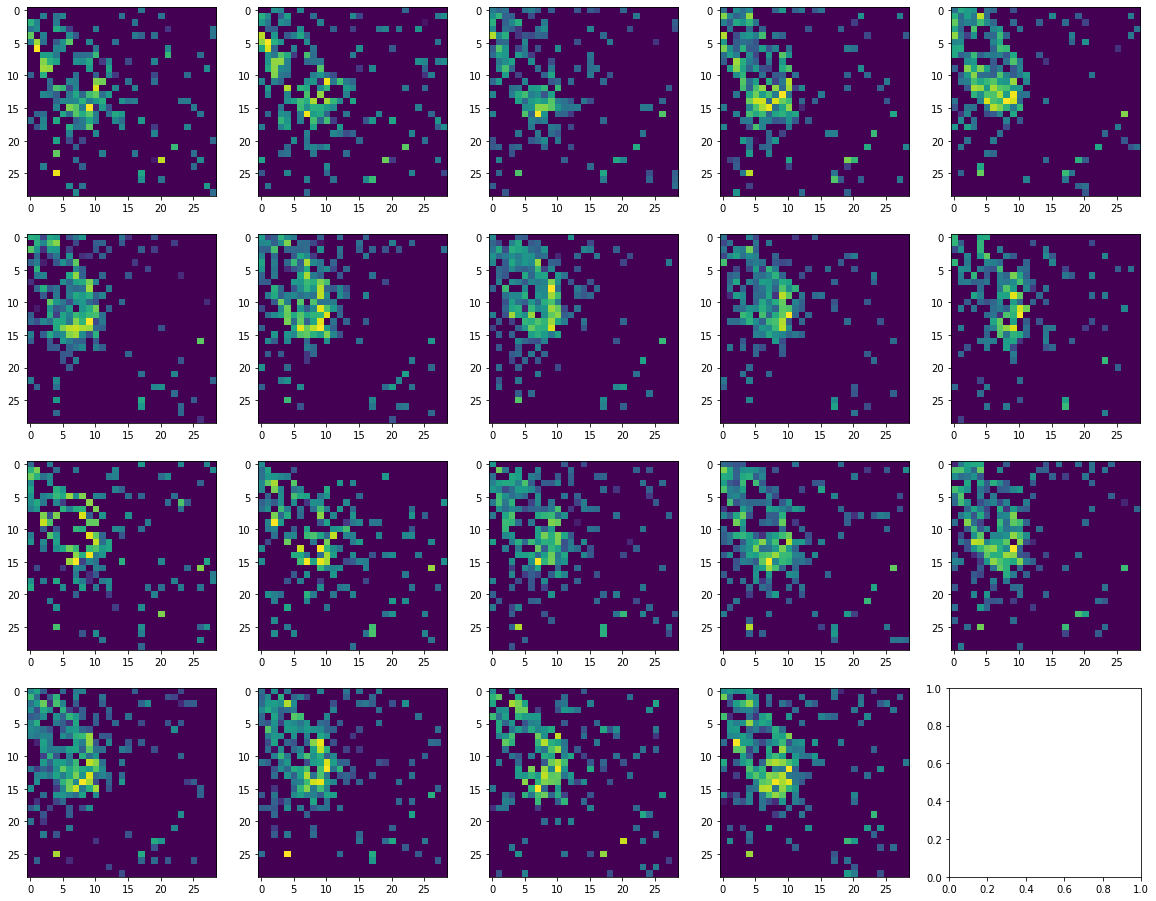

In [5]:
fig, axes = plt.subplots(4,5,figsize=(20,16),facecolor='w')
for l in range(19):
    im = axes[int(l/5),int(l%5)].imshow(np.log(event_data[2,:,:,l]+0.5))

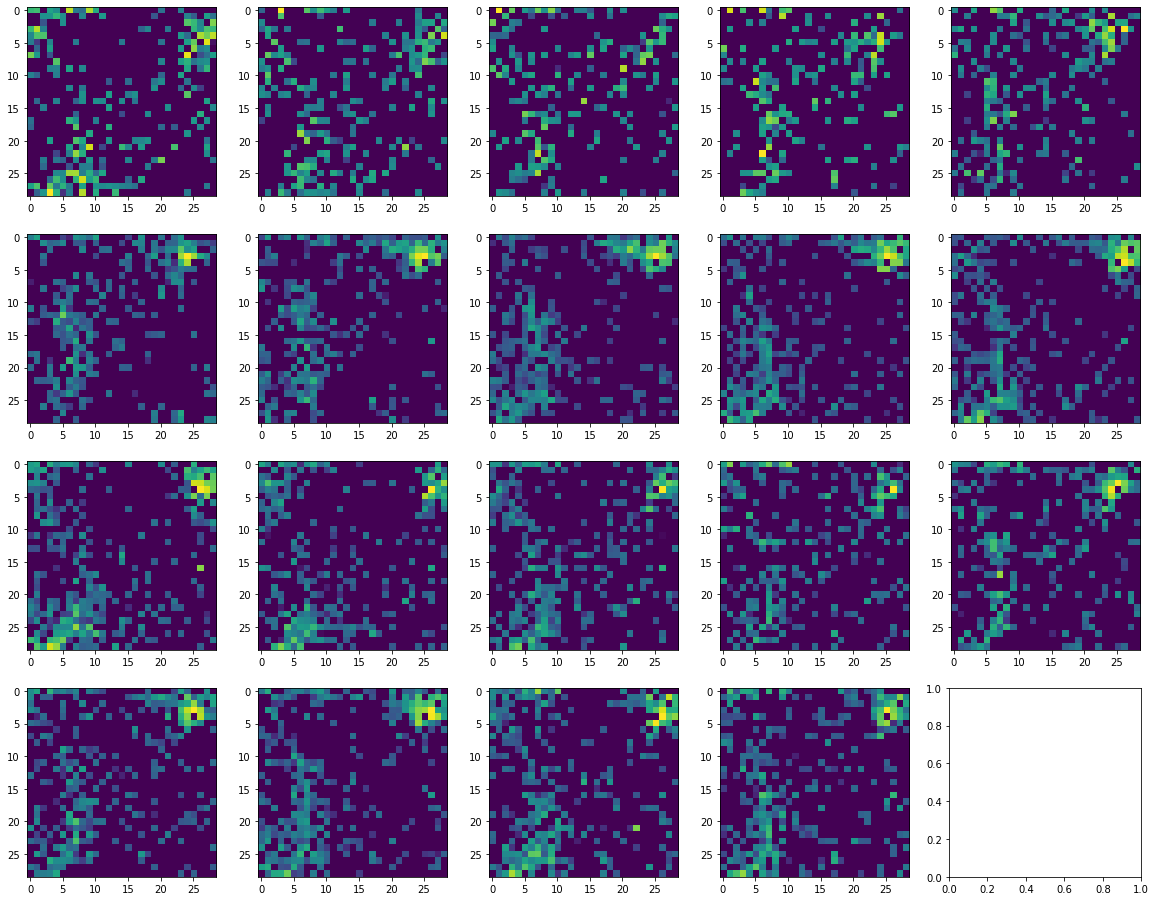

In [6]:
fig, axes = plt.subplots(4,5,figsize=(20,16),facecolor='w')
for l in range(19):
    im = axes[int(l/5),int(l%5)].imshow(np.log(event_data[11,:,:,l]+0.5))

In [7]:
def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

## Train network

In [10]:
from torch.utils.data import Dataset, DataLoader

class H5Dataset(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 0: # gamma
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        event_data = fh['event_data'][entry_index]
        # convert event data to complex rep
        evQ = event_data[:,:, 0:19]
        #evT = event_data[:,:,19:38]
        #evR = np.power(evQ,0.25);
        #evA = 2*np.pi*(evT-960.)/(1900.-600.)
        #evX = evR*np.cos(evA);
        #evY = evR*np.sin(evA);
        return np.concatenate([evQ],2),label,idx,fh['positions'][entry_index,0],fh['directions'][entry_index,0],np.sum(fh['energies'][entry_index,:])
        # the ,0 in positions and directions selects the pos/dir for the first track (in case of gamma)
        # thus positions and directions are just np arrays with 3 elements

def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    pos   = np.stack([sample[3] for sample in batch])
    direc = np.stack([sample[4] for sample in batch])
    ene   = np.stack([sample[5] for sample in batch])
    return data,label,idx,pos,direc,ene

In [11]:
mcdir = '/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo_mPMTAsLayers'
pnames = ('e-','mu-')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(60) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size=64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# based on https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicGeomBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicGeomBlock, self).__init__()
        
        self.pad = 1
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=2*self.pad+1, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=2*self.pad+1,
                               stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(geometricPad(x,self.pad))))
        out = self.bn2(self.conv2(geometricPad(out,self.pad)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetGeom(nn.Module):
    def __init__(self, block, num_blocks, num_classes=3):
        super(ResNetGeom, self).__init__()
        self.in_planes = 64
        overall_in_planes = 19 # here 19 instead of 38
        self.pad = 1
        
        # (38,29,29)
        self.conv1 = nn.Conv2d(overall_in_planes, 32, kernel_size=1,
                               stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        # (32,29,29)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1,
                               stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        # (64,29,29)
        self.layer0 = block(64, 64)
        # (64,29,29)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=2)
        # outsize = floor[(29+2*self.pad-3)/stride + 1]
        #      (64,15,15)
        self.layer2 = self._make_layer(block,  64, num_blocks[1], stride=2)
        #      (64, 8, 8)
        self.layer3 = self._make_layer(block,  64, num_blocks[2], stride=2)
        #      (64, 4, 4)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        #      (128,2, 2)
        self.convbn5 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=2,stride=1,padding=0),
            nn.BatchNorm2d(128)
        )
        #      (128,1, 1)
        # transform to 128, then
        self.linear1 = nn.Linear(int(128*block.expansion),   int(128*block.expansion/2))
        self.linear2 = nn.Linear(int(128*block.expansion/2), int(128*block.expansion/4))
        self.linear3 = nn.Linear(int(128*block.expansion/4), int(128*block.expansion/8))
        self.linear4 = nn.Linear(int(128*block.expansion/8), num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.layer0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.convbn5(out))
        #out = F.avg_pool2d(out, out.shape[2:4])
        out = out.view(out.size(0), -1)
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        return out

#    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
#    
#    def cpu(self):
#        super(GeomCNN, self).cpu()
#        for module in self._feature:
#            module.cpu()
#        for module in self._classifier:
#            module.cpu()
#        return self
#    
#    def cuda(self):
#        super(GeomCNN, self).cuda()
#        for module in self._feature:
#            module.cuda()
#        for module in self._classifier:
#            module.cuda()
#        return self

def ResNetGeom18(num_classes):
    return ResNetGeom(BasicGeomBlock, [2, 2, 2, 2], num_classes)

In [13]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (blob.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

# weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
# print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [14]:
class BLOB:
    pass
blob=BLOB()
blob.net       = ResNetGeom18(2).cuda() # construct ResNet for 2 class classification, use GPU
# just the training weights is ~640MiB
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.prefix    = '20200708-11c-IWCD19-ResNetGeom-chargeonly-03-e-mu'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [15]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train.csv' % blob.prefix), CSVData('%s-log_test.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=4.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        #print(blob.data.shape)
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[blob.iteration,blob.epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (blob.iteration,blob.epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[blob.iteration,blob.epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (blob.iteration,blob.epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

Epoch 0 Starting @ 2020-07-18 02:14:24


Epoch 1 Starting @ 2020-07-18 02:25:07


Epoch 2 Starting @ 2020-07-18 02:35:45


Epoch 3 Starting @ 2020-07-18 02:46:38


In [ ]:
# to follow status in R

def Rcode:
    prefix='20200708-11c-IWCD19-ResNetGeom-chargeonly-03-e-mu'

    ma <- function(x, n = 5){filter(x, rep(1 / n, n), sides = 2)}

    maxepochs = 4.
    dfTrain = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_train.csv", prefix))
    )
    dfTest = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_test.csv", prefix))
    )


    par(mfrow=c(1,2))
    w=100
    plot(c(ma(loss,w)) ~ c(ma(epoch,w)), dfTrain, 'l', col='green', xlab='Epoch', ylab='Loss', xaxs='i', xlim=c(0.,maxepochs))
    lines(c(ma(loss,w/2)) ~ c(ma(epoch,w/2)), dfTest, col='blue')

    plot(c(ma(accuracy,w)) ~ c(ma(epoch,w)), dfTrain, 'l', col='orange', xlab='Epoch', ylab='Accuracy', xlim=c(0.,maxepochs), ylim=c(0.,1.), xaxs='i', yaxs='i')
    lines(c(ma(accuracy,w/2)) ~ c(ma(epoch,w/2)), dfTest, col='red')

In [ ]:
# compare with Q+T

def Rcode():
    prefix='20200708-11c-IWCD19-ResNetGeom-chargeonly-03-e-mu'
    prefixRef='20200708-11-IWCD19-ResNetGeom-01-e-mu'
    legLabels = c('Charge', 'Charge+Time') # (prefix,prefixRef)

    ma <- function(x, n = 5){filter(x, rep(1 / n, n), sides = 2)}

    maxepochs = 4.
    dfTrain = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_train.csv", prefix))
    )
    dfTest = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_test.csv", prefix))
    )

    dfTrainRef = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_train.csv", prefixRef))
    )
    dfTestRef = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_test.csv", prefixRef))
    )
    
    dfPlot = dfTrain
    dfPlotRef = dfTrainRef


    par(mfrow=c(1,2))
    w=100
    plot(c(ma(loss,w)) ~ c(ma(epoch,w)), dfPlotRef, 'l', col='green', xlab='Epoch', ylab='Loss', xaxs='i', xlim=c(0.,maxepochs))
    lines(c(ma(loss,w)) ~ c(ma(epoch,w)), dfPlot, col='blue')
    legend('topright', legLabels, col=c('blue','green'), lty=1)

    plot(c(ma(accuracy,w)) ~ c(ma(epoch,w)), dfPlotRef, 'l', col='orange', xlab='Epoch', ylab='Accuracy', xlim=c(0.,maxepochs), ylim=c(0.,1.), xaxs='i', yaxs='i')
    lines(c(ma(accuracy,w)) ~ c(ma(epoch,w)), dfPlot, col='red')
    legend('bottomright', legLabels, col=c('red','orange'), lty=1)

In [ ]:
# compare with Q^(1/4)

def Rcode():
    prefix='20200708-11c-IWCD19-ResNetGeom-chargeonly-03-e-mu'
    prefixRef='20200708-11b-IWCD19-ResNetGeom-chargeonly-02-e-mu'
    legLabels = c('Q', 'Q^0.25') # (prefix,prefixRef)

    ma <- function(x, n = 5){filter(x, rep(1 / n, n), sides = 2)}

    maxepochs = 4.
    dfTrain = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_train.csv", prefix))
    )
    dfTest = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_test.csv", prefix))
    )

    dfTrainRef = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_train.csv", prefixRef))
    )
    dfTestRef = rbind(
      read.csv(sprintf("/home/lukasb/watchmal/DataTools/root_utils/notebooks/%s-log_test.csv", prefixRef))
    )
    
    dfPlot = dfTrain
    dfPlotRef = dfTrainRef


    par(mfrow=c(1,2))
    w=100
    plot(c(ma(loss,w)) ~ c(ma(epoch,w)), dfPlotRef, 'l', col='green', xlab='Epoch', ylab='Loss', xaxs='i', xlim=c(0.,maxepochs))
    lines(c(ma(loss,w)) ~ c(ma(epoch,w)), dfPlot, col='blue')
    legend('topright', legLabels, col=c('blue','green'), lty=1)

    plot(c(ma(accuracy,w)) ~ c(ma(epoch,w)), dfPlotRef, 'l', col='orange', xlab='Epoch', ylab='Accuracy', xlim=c(0.,maxepochs), ylim=c(0.,1.), xaxs='i', yaxs='i')
    lines(c(ma(accuracy,w)) ~ c(ma(epoch,w)), dfPlot, col='red')
    legend('bottomright', legLabels, col=c('red','orange'), lty=1)

In [ ]:
save_state(blob)

In [ ]:
# restore_state(blob, 10128)

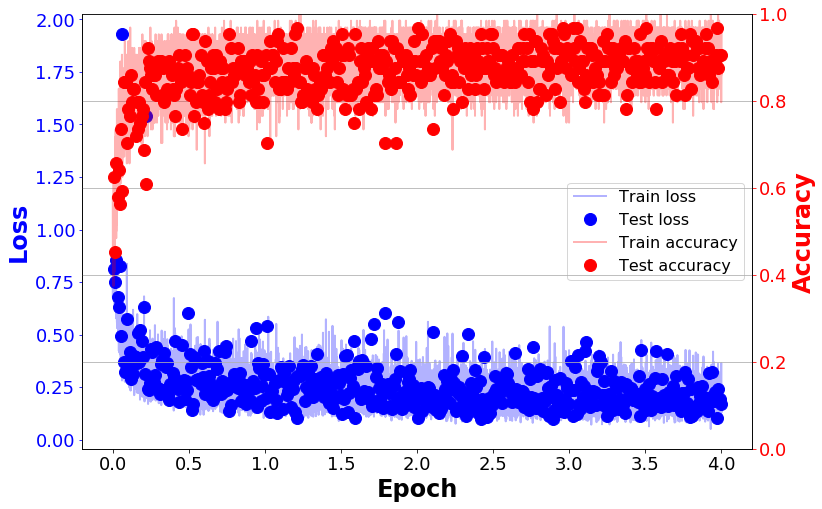

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

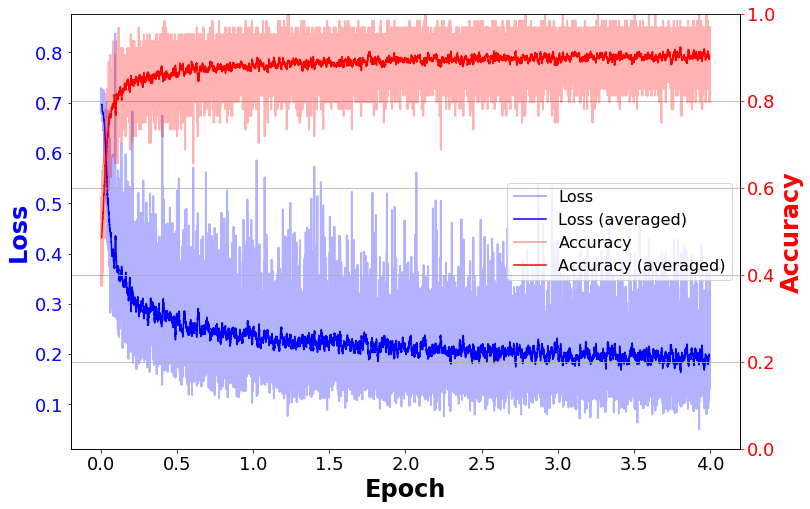

In [17]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

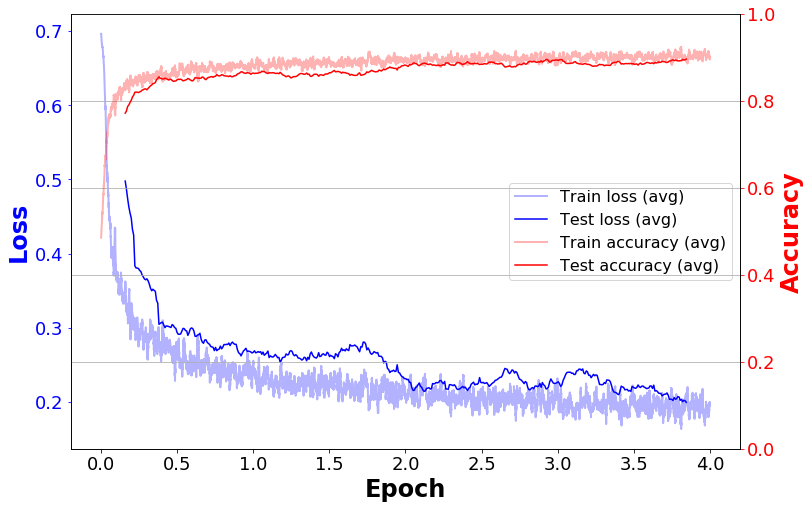

In [18]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

train_epoch        = moving_average(np.array(train_log.epoch),40)
train_accuracy_mav = moving_average(np.array(train_log.accuracy),40)
train_loss_mav     = moving_average(np.array(train_log.loss),40)

test_epoch        = moving_average(np.array(test_log.epoch),40)
test_accuracy_mav = moving_average(np.array(test_log.accuracy),40)
test_loss_mav     = moving_average(np.array(test_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_epoch, train_loss_mav, linewidth=2, label='Train loss (avg)', color='b', alpha=0.3)
line12 = ax1.plot(test_epoch, test_loss_mav, label='Test loss (avg)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_epoch, train_accuracy_mav, linewidth=2, label='Train accuracy (avg)', color='r', alpha=0.3)
line22 = ax2.plot(test_epoch, test_accuracy_mav, label='Test accuracy (avg)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [19]:
def inferenceWithSoftmax(blob,data_loader):
    label,prediction,accuracy,softmax,positions,directions,energies=[],[],[],[],[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        position  = data[3]
        direction = data[4]
        energy    = data[5]
        res = forward(blob,train=False)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        softmax.append(res['softmax'])
        label.append(blob.label)
        positions.append(position)
        directions.append(direction)
        energies.append(energy)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    softmax    = np.vstack(softmax)
    positions  = np.vstack(positions)
    directions = np.vstack(directions)
    energies   = np.concatenate(energies)
    
    return accuracy, label, prediction, softmax, positions, directions, energies

In [20]:
accuracy,label,prediction,softmax,positions,directions,energies = inferenceWithSoftmax(blob,test_loader)

In [21]:
#label,prediction,softmax,positions,directions
np.savetxt('%s-inference.csv' % blob.prefix,
           np.hstack([np.expand_dims(label,1),np.expand_dims(prediction,1),softmax,positions,directions]),
           delimiter=','
          )

## compare

In [22]:
def sepCurve(fig, infSet, lineLabel):
    label   = infSet[:,0].astype(int)
    softmax = infSet[:,2:4]
    
    llr_order = np.argsort(np.log(softmax[:,1]/softmax[:,0]))
    cumsum_true0 = np.cumsum((label == 0)[llr_order]) / np.sum(label == 0)
    cumsum_true1 = np.cumsum((label == 1)[llr_order]) / np.sum(label == 1)
    
    fig.plot(cumsum_true0[cumsum_true1>0], 1./cumsum_true1[cumsum_true1>0], label=lineLabel)

In [27]:
#label,prediction,softmax,positions,directions
infChrgTime = np.loadtxt('%s-inference_epoch4.csv' % '20200708-11-IWCD19-ResNetGeom-01-e-mu', delimiter=',')
infChrgQuad = np.loadtxt('%s-inference.csv' % '20200708-11b-IWCD19-ResNetGeom-chargeonly-02-e-mu', delimiter=',')
infChrgOnly = np.loadtxt('%s-inference.csv' % blob.prefix, delimiter=',')

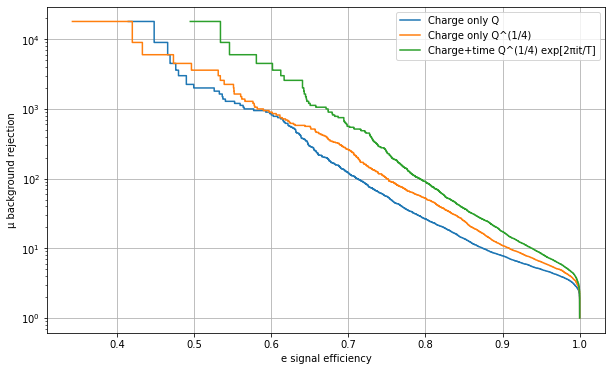

In [32]:
fig = plt.figure(figsize=[10,6])
sepCurve(plt, infChrgOnly, 'Charge only Q')
sepCurve(plt, infChrgQuad, 'Charge only Q^(1/4)')
sepCurve(plt, infChrgTime, 'Charge+time Q^(1/4) exp[2πit/T]')
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("e signal efficiency")
plt.ylabel("μ background rejection")
plt.grid()
plt.legend(loc='upper right')
plt.show()

## train more epochs

In [ ]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train_epoch4to8.csv' % blob.prefix), CSVData('%s-log_test_epoch4to8.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=8.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[blob.iteration,blob.epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (blob.iteration,blob.epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[blob.iteration,blob.epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (blob.iteration,blob.epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

In [ ]:
save_state(blob)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

train_epoch        = moving_average(np.array(train_log.epoch),40)
train_accuracy_mav = moving_average(np.array(train_log.accuracy),40)
train_loss_mav     = moving_average(np.array(train_log.loss),40)

test_epoch        = moving_average(np.array(test_log.epoch),40)
test_accuracy_mav = moving_average(np.array(test_log.accuracy),40)
test_loss_mav     = moving_average(np.array(test_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_epoch, train_loss_mav, linewidth=2, label='Train loss (avg)', color='b', alpha=0.3)
line12 = ax1.plot(test_epoch, test_loss_mav, label='Test loss (avg)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_epoch, train_accuracy_mav, linewidth=2, label='Train accuracy (avg)', color='r', alpha=0.3)
line22 = ax2.plot(test_epoch, test_accuracy_mav, label='Test accuracy (avg)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [ ]:
accuracy,label,prediction,softmax,positions,directions,energies = inferenceWithSoftmax(blob,test_loader)

In [ ]:
#label,prediction,softmax,positions,directions
np.savetxt('%s-inference.csv' % blob.prefix,
           np.hstack([np.expand_dims(label,1),np.expand_dims(prediction,1),softmax,positions,directions]),
           delimiter=','
          )

## train with more data

In [ ]:
mcdir = '/home/lukasb/watchmal/data/IWCDmPMT_4pi_full_tank/h5_topo_mPMTAsLayers'
pnames = ('e-','mu-')
files = ['%s/%s/IWCDmPMT_4pi_full_tank_%s_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_%d.h5' % (mcdir,pname,pname,bch+100) for bch in range(300) for pname in pnames]

train_ds = H5Dataset(files,start_fraction=0.0,use_fraction=0.9);
test_ds  = H5Dataset(files,start_fraction=0.9,use_fraction=0.1);

# for training
train_loader=DataLoader(train_ds,batch_size=64,shuffle=True,num_workers=4,collate_fn=HKCollate)
# for validation
test_loader =DataLoader( test_ds,batch_size=64,shuffle=True,num_workers=2,collate_fn=HKCollate)

In [ ]:
import time
from utils.utils import progress_bar, CSVData

blob.train_log, blob.test_log = CSVData('%s-log_train_epoch8to12.csv' % blob.prefix), CSVData('%s-log_test_epoch8to12.csv' % blob.prefix)

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=12.0
# Set the network to training mode
blob.net.train()

# Start training
while int(blob.epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(blob.epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        blob.epoch += 1./len(train_loader)
        blob.iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[blob.iteration,blob.epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (blob.iteration,blob.epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%40 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[blob.iteration,blob.epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        # even more rarely, save state
        if (i+1)%400 == 0:
            with torch.no_grad():
                blob.net.eval()
                save_state(blob)
            blob.net.train()
        if blob.epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (blob.iteration,blob.epoch,res['loss'],res['accuracy'])
    #print(message)
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

In [ ]:
save_state(blob)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

In [ ]:
accuracy,label,prediction,softmax,positions,directions,energies = inferenceWithSoftmax(blob,test_loader)

In [ ]:
#label,prediction,softmax,positions,directions
np.savetxt('%s-inference_epoch12.csv' % blob.prefix,
           np.hstack([np.expand_dims(label,1),np.expand_dims(prediction,1),softmax,positions,directions]),
           delimiter=','
          )

## compare

In [ ]:
def sepCurve(fig, infSet, lineLabel):
    label   = infSet[:,0].astype(int)
    softmax = infSet[:,2:4]
    
    llr_order = np.argsort(np.log(softmax[:,1]/softmax[:,0]))
    cumsum_true0 = np.cumsum((label == 0)[llr_order]) / np.sum(label == 0)
    cumsum_true1 = np.cumsum((label == 1)[llr_order]) / np.sum(label == 1)
    
    fig.plot(cumsum_true0[cumsum_true1>0], 1./cumsum_true1[cumsum_true1>0], label=lineLabel)

In [ ]:
#label,prediction,softmax,positions,directions
infWiTopo1 = np.loadtxt('%s-inference_epoch12.csv' % '20200708-04-IWCD-SmallResNetGeom-timeCmplx-01-e-mu', delimiter=',')
infWiTopo2 = np.loadtxt('%s-inference_epoch12.csv' % '20200708-04c-IWCD-SmallResNetGeom-timeCmplx-02-e-mu', delimiter=',')
infL19Topo = np.loadtxt('%s-inference_epoch12.csv' % blob.prefix, delimiter=',')

In [ ]:
fig = plt.figure(figsize=[10,6])
sepCurve(plt, infWiTopo1, 'Single layer')
sepCurve(plt, infL19Topo, '19 layers')
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("e signal efficiency")
plt.ylabel("μ background rejection")
plt.grid()
plt.legend(loc='upper right')
plt.show()

In [ ]:
fig = plt.figure(figsize=[10,6])
sepCurve(plt, infWiTopo1, 'Single layer')
sepCurve(plt, infL19Topo, '19 layers')
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("e signal efficiency")
plt.ylabel("μ background rejection")
plt.grid()
plt.legend(loc='upper right')
plt.xlim([0.75,1.0])
plt.ylim([1e0, 1e3])
plt.show()